### Function Approximation

Previous we tried using manually created buckets to discretize continuous states, effectively mapping continuous observations to discrete states. Great, but, isn't that what Supervised Learning is for? How about we use the power of function approximators to do that mapping for us???

Let's do just that!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tempfile
import base64
import pprint
import random
import json
import sys
import gym
import io

from gym import wrappers
from collections import deque
from subprocess import check_output
from IPython.display import HTML

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


As with previous notebooks we will use an action selection function to give us an exploration strategy. Feel free to change this function and play with it to see what happens. For now, let me just provide a couple function.

In [2]:
def action_selection(state, model, episode, n_episodes):
    epsilon = 0.99 if episode < n_episodes//4 else 0.33 if episode < n_episodes//2 else 0.
    values = model.predict(state.reshape(1, 4))[0]
    if np.random.random() < epsilon:
        action = np.random.randint(len(values))
    else:
        action = np.argmax(values)
    return action, epsilon

In [3]:
def neuro_q_learning(env, gamma = 0.99):
    nS = env.observation_space.shape[0]
    nA = env.env.action_space.n
    
    # memory bank
    memory_bank = deque()
    memory_bank_size = 100000
    
    # function approximator
    model = Sequential()
    model.add(Dense(64, input_dim=nS, activation='relu'))
    model.add(Dense(nA, activation='linear'))
    model.compile(loss='mse', optimizer='adam')

    # constant values
    n_episodes = 50000
    batch_size = 256
    training_frequency = 20
    
    # for statistics
    epsilons = []
    states = []
    actions = []
    
    # interactions
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        
        # each episode
        while not done:
            states.append(state)
            
            # select action
            action, epsilon = action_selection(state, model, episode, n_episodes)
            epsilons.append(epsilon)
            actions.append(action)
            
            # save history in memory bank
            nstate, reward, done, info = env.step(action)
            memory_bank.append((state, action, reward, nstate, done))
            if len(memory_bank) > memory_bank_size:
                memory_bank.popleft()
            
            # iterate to next state
            state = nstate

        # only every few episodes enter training and update neural network weights
        if episode % training_frequency == 0 and len(memory_bank) == memory_bank_size:
            
            # randomly select batches of samples from the history
            # for training to prevent values spiking due to high 
            # correlation of sequential values
            minibatch = np.array(random.sample(memory_bank, batch_size))

            # extract values by type from the minibatch
            state_batch = np.array(minibatch[:,0].tolist())
            action_batch = np.array(minibatch[:,1].tolist())
            rewards_batch = np.array(minibatch[:,2].tolist())
            state_prime_batch = np.array(minibatch[:,3].tolist())
            is_terminal_batch = np.array(minibatch[:,4].tolist())

            # use the current neural network to predict 
            # current state values and next state values
            state_value_batch = model.predict(state_batch)
            next_state_value_batch = model.predict(state_prime_batch)

            # update the state values given the batch
            for i in range(len(minibatch)):
                if is_terminal_batch[i]:
                    state_value_batch[i, action_batch[i]] = rewards_batch[i]
                else:
                    state_value_batch[i, action_batch[i]] = rewards_batch[i] + gamma * np.max(next_state_value_batch[i])
            
            # update the neural network weights
            model.train_on_batch(state_batch, state_value_batch)

    return model, (epsilons, states, actions)

Did you see that `neuro_q_learning` function??? I had to add comments to this one to make it easier to understand. There are a couple of things that you might want to read about. Check out the "Further reading" sections on the README.md files for that. 

For example, did you see we are now saving experiences into a `memory_bank`? That is called experience replay. Now, we don't just go over the saved tuples sequentially, we randomly select a batch of sample and update the neural network weights with that. This is important often due to the high correlation of the samples.

Also, did you see how we update the `state_value_batch` with each sample? That is just very cool, we are not using `alpha` here anymore, the learning rate is now used for gradient descent when we are learning the network weights.

Ok, let's run this algorithm!

Beware, this will take some time... go get your favorite beverage.

In [4]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

model, stats = neuro_q_learning(env)

[2017-04-26 19:34:34,843] Making new env: CartPole-v0
[2017-04-26 19:34:34,910] Starting new video recorder writing to /tmp/tmpkc1h_x_k/openaigym.video.0.1418.video000000.mp4
[2017-04-26 19:34:35,426] Starting new video recorder writing to /tmp/tmpkc1h_x_k/openaigym.video.0.1418.video000001.mp4
[2017-04-26 19:34:35,662] Starting new video recorder writing to /tmp/tmpkc1h_x_k/openaigym.video.0.1418.video000008.mp4
[2017-04-26 19:34:36,346] Starting new video recorder writing to /tmp/tmpkc1h_x_k/openaigym.video.0.1418.video000027.mp4
[2017-04-26 19:34:36,792] Starting new video recorder writing to /tmp/tmpkc1h_x_k/openaigym.video.0.1418.video000064.mp4
[2017-04-26 19:34:37,340] Starting new video recorder writing to /tmp/tmpkc1h_x_k/openaigym.video.0.1418.video000125.mp4
[2017-04-26 19:34:38,013] Starting new video recorder writing to /tmp/tmpkc1h_x_k/openaigym.video.0.1418.video000216.mp4
[2017-04-26 19:34:38,935] Starting new video recorder writing to /tmp/tmpkc1h_x_k/openaigym.video.0

Hope you enjoyed your vacations. :)

Back to it. Let's look at a couple of episodes to see how the agent did.

In [5]:
videos = np.array(env.videos)
n_videos = 4

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

Let's close up the environment and upload (in case you want to).

In [6]:
env.close()

[2017-04-26 19:51:32,930] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpkc1h_x_k')


In [7]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-26 19:51:32,974] [CartPole-v0] Uploading 50000 episodes of training data
[2017-04-26 19:51:37,095] [CartPole-v0] Uploading videos of 59 training episodes (294651 bytes)
[2017-04-26 19:51:37,736] [CartPole-v0] Creating evaluation object from /tmp/tmpkc1h_x_k with learning curve and training video
[2017-04-26 19:51:37,978] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_ansfccvzQBGTWxZV1g3SzA

****************************************************


Now, let's look at some of the statistics 

In [8]:
epsilons, states, actions = stats

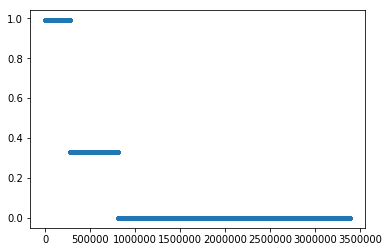

In [9]:
plt.plot(np.arange(len(epsilons)), epsilons, '.')

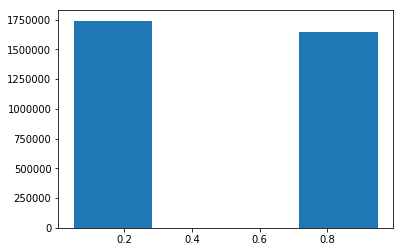

In [10]:
hist, bins = np.histogram(actions, bins=3)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

Cool, not bad at all!

Let's test this fully trained agent and see how it does.

In [11]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

for episode in range(100):
    state = env.reset()
    done = False
    while not done:
        action = np.argmax(model.predict(state.reshape(1, 4))[0])
        nstate, reward, done, info = env.step(action)
        state = nstate

[2017-04-26 19:51:42,647] Making new env: CartPole-v0
[2017-04-26 19:51:42,666] Starting new video recorder writing to /tmp/tmpbj36uk9x/openaigym.video.1.1418.video000000.mp4
[2017-04-26 19:51:44,091] Starting new video recorder writing to /tmp/tmpbj36uk9x/openaigym.video.1.1418.video000001.mp4
[2017-04-26 19:51:45,938] Starting new video recorder writing to /tmp/tmpbj36uk9x/openaigym.video.1.1418.video000008.mp4
[2017-04-26 19:51:47,948] Starting new video recorder writing to /tmp/tmpbj36uk9x/openaigym.video.1.1418.video000027.mp4
[2017-04-26 19:51:51,204] Starting new video recorder writing to /tmp/tmpbj36uk9x/openaigym.video.1.1418.video000064.mp4


In [12]:
videos = np.array(env.videos)
n_videos = 3

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

In [13]:
env.close()

[2017-04-26 19:51:55,037] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpbj36uk9x')


In [15]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-26 19:57:18,333] [CartPole-v0] Uploading 100 episodes of training data
[2017-04-26 19:57:18,960] [CartPole-v0] Uploading videos of 5 training episodes (59482 bytes)
[2017-04-26 19:57:19,343] [CartPole-v0] Creating evaluation object from /tmp/tmpbj36uk9x with learning curve and training video
[2017-04-26 19:57:19,617] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_9GmUYkMTDO639hU9KdeCQ

****************************************************


Nice, the agent is good, but it could use some help. It seems the agent is learning, but perhaps not enough. Try modifying the neural network... Maybe more layers? Larger hidden layers?? Try things out, it's now your turn.

In [16]:
def action_selection(state, model, episode, n_episodes):
    epsilon = 0.99 if episode < n_episodes//4 else 0.33 if episode < n_episodes//2 else 0.
    values = model.predict(state.reshape(1, 4))[0]
    if np.random.random() < epsilon:
        action = np.random.randint(len(values))
    else:
        action = np.argmax(values)
    return action, epsilon

In [17]:
def neuro_q_learning(env, gamma = 0.99):
    nS = env.observation_space.shape[0]
    nA = env.env.action_space.n
    
    # memory bank
    memory_bank = deque()
    memory_bank_size = 100000
    
    # function approximator
    model = Sequential()
    model.add(Dense(128, input_dim=nS, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(nA, activation='linear'))
    model.compile(loss='mse', optimizer='adam')

    # constant values
    n_episodes = 50000
    batch_size = 256
    training_frequency = 20
    
    # for statistics
    epsilons = []
    states = []
    actions = []
    
    # interactions
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        
        # each episode
        while not done:
            states.append(state)
            
            # select action
            action, epsilon = action_selection(state, model, episode, n_episodes)
            epsilons.append(epsilon)
            actions.append(action)
            
            # save history in memory bank
            nstate, reward, done, info = env.step(action)
            memory_bank.append((state, action, reward, nstate, done))
            if len(memory_bank) > memory_bank_size:
                memory_bank.popleft()
            
            # iterate to next state
            state = nstate

        # only every few episodes enter training and update neural network weights
        if episode % training_frequency == 0 and len(memory_bank) == memory_bank_size:
            
            # randomly select batches of samples from the history
            # for training to prevent values spiking due to high 
            # correlation of sequential values
            minibatch = np.array(random.sample(memory_bank, batch_size))

            # extract values by type from the minibatch
            state_batch = np.array(minibatch[:,0].tolist())
            action_batch = np.array(minibatch[:,1].tolist())
            rewards_batch = np.array(minibatch[:,2].tolist())
            state_prime_batch = np.array(minibatch[:,3].tolist())
            is_terminal_batch = np.array(minibatch[:,4].tolist())

            # use the current neural network to predict 
            # current state values and next state values
            state_value_batch = model.predict(state_batch)
            next_state_value_batch = model.predict(state_prime_batch)

            # update the state values given the batch
            for i in range(len(minibatch)):
                if is_terminal_batch[i]:
                    state_value_batch[i, action_batch[i]] = rewards_batch[i]
                else:
                    state_value_batch[i, action_batch[i]] = rewards_batch[i] + gamma * np.max(next_state_value_batch[i])
            
            # update the neural network weights
            model.train_on_batch(state_batch, state_value_batch)

    return model, (epsilons, states, actions)

Let's test thing puppy.

In [18]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

model, stats = neuro_q_learning(env)

[2017-04-26 19:57:54,544] Making new env: CartPole-v0
[2017-04-26 19:57:54,609] Starting new video recorder writing to /tmp/tmpa2d2gyxr/openaigym.video.2.1418.video000000.mp4
[2017-04-26 19:57:54,893] Starting new video recorder writing to /tmp/tmpa2d2gyxr/openaigym.video.2.1418.video000001.mp4
[2017-04-26 19:57:55,191] Starting new video recorder writing to /tmp/tmpa2d2gyxr/openaigym.video.2.1418.video000008.mp4
[2017-04-26 19:57:55,497] Starting new video recorder writing to /tmp/tmpa2d2gyxr/openaigym.video.2.1418.video000027.mp4
[2017-04-26 19:57:56,004] Starting new video recorder writing to /tmp/tmpa2d2gyxr/openaigym.video.2.1418.video000064.mp4
[2017-04-26 19:57:56,769] Starting new video recorder writing to /tmp/tmpa2d2gyxr/openaigym.video.2.1418.video000125.mp4
[2017-04-26 19:57:57,577] Starting new video recorder writing to /tmp/tmpa2d2gyxr/openaigym.video.2.1418.video000216.mp4
[2017-04-26 19:57:58,734] Starting new video recorder writing to /tmp/tmpa2d2gyxr/openaigym.video.2

Wake upp!!!

In [19]:
videos = np.array(env.videos)
n_videos = 4

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

In [20]:
env.close()

[2017-04-26 20:08:54,315] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmpa2d2gyxr')


In [21]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-26 20:08:54,359] [CartPole-v0] Uploading 50000 episodes of training data
[2017-04-26 20:08:58,186] [CartPole-v0] Uploading videos of 59 training episodes (218203 bytes)
[2017-04-26 20:08:58,714] [CartPole-v0] Creating evaluation object from /tmp/tmpa2d2gyxr with learning curve and training video
[2017-04-26 20:08:58,989] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_ghlZ4ETiOQpKCHSm7cg

****************************************************


You happy with it????? Are you sure????

If you have any issues, check out my solution. But don't do befere you spend a good deal of time on this one.

Let's look into the stats.

In [22]:
epsilons, states, actions = stats

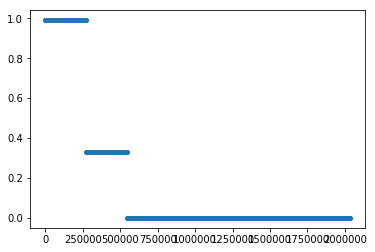

In [23]:
plt.plot(np.arange(len(epsilons)), epsilons, '.')

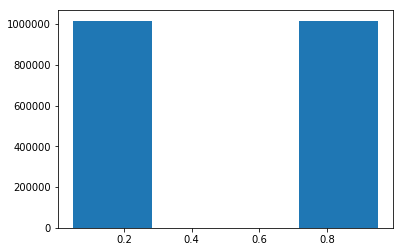

In [24]:
hist, bins = np.histogram(actions, bins=3)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

How about running your fully-trained greedy agent?

In [25]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True)

for episode in range(100):
    state = env.reset()
    done = False
    while not done:
        action = np.argmax(model.predict(state.reshape(1, 4))[0])
        nstate, reward, done, info = env.step(action)
        state = nstate

[2017-04-26 20:09:02,440] Making new env: CartPole-v0
[2017-04-26 20:09:02,453] Starting new video recorder writing to /tmp/tmprkc4htq8/openaigym.video.3.1418.video000000.mp4
[2017-04-26 20:09:04,081] Starting new video recorder writing to /tmp/tmprkc4htq8/openaigym.video.3.1418.video000001.mp4
[2017-04-26 20:09:05,973] Starting new video recorder writing to /tmp/tmprkc4htq8/openaigym.video.3.1418.video000008.mp4
[2017-04-26 20:09:08,599] Starting new video recorder writing to /tmp/tmprkc4htq8/openaigym.video.3.1418.video000027.mp4
[2017-04-26 20:09:12,596] Starting new video recorder writing to /tmp/tmprkc4htq8/openaigym.video.3.1418.video000064.mp4


In [26]:
videos = np.array(env.videos)
n_videos = 3

idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
videos = videos[idxs,:]

strm = ''
for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    
    with open(meta_path) as data_file:    
        meta = json.load(data_file)

    html_tag = """
    <h2>{0}<h2/>
    <video width="960" height="540" controls>
        <source src="data:video/mp4;base64,{1}" type="video/mp4" />
    </video>"""
    strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
HTML(data=strm)

In [27]:
env.close()

[2017-04-26 20:09:16,888] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/tmprkc4htq8')


In [28]:
gym.upload(mdir, api_key='<YOUR API KEY>')

[2017-04-26 20:09:17,431] [CartPole-v0] Uploading 100 episodes of training data
[2017-04-26 20:09:18,139] [CartPole-v0] Uploading videos of 5 training episodes (74783 bytes)
[2017-04-26 20:09:18,611] [CartPole-v0] Creating evaluation object from /tmp/tmprkc4htq8 with learning curve and training video
[2017-04-26 20:09:18,933] 
****************************************************
You successfully uploaded your evaluation on CartPole-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_VxzNknfHSOO1ukCE89lcNw

****************************************************


Good??

Good enough????

Perfect??????

Just so you know, this guy can average 200 points, which is the max. If that is not the case, keep trying!

When you are done comeback to the next notebooks. The topics coming later are a bit more advanced, but I'd like to at least give some intuition. If you are onboard, great. Let's move on.